In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.0091635 , -0.01171564, -0.03937805, -0.02005912], dtype=float32)

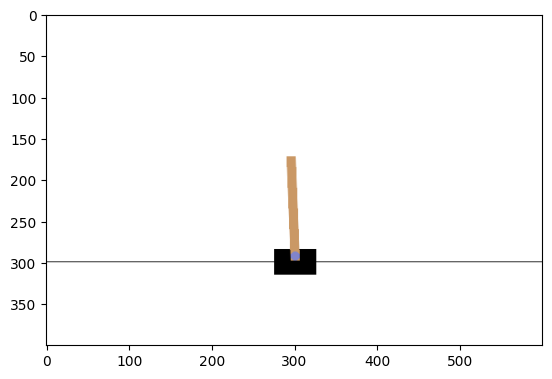

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch

model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),
)

model_action(torch.randn(2, 4))

tensor([[0.6136, 0.3864],
        [0.6010, 0.3990]], grad_fn=<SoftmaxBackward0>)

In [4]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

model_value_next1 = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

model_value_next2 = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[ 0.1294, -0.2356],
        [ 0.0668, -0.2346]], grad_fn=<AddmmBackward0>)

In [5]:
import random


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    prob = model_action(state)

    #根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])

0

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step(action)

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 10000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((203, 0), 203)

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/tmp/ipykernel_2238/1417522126.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)


(tensor([[ 0.0860,  0.8179, -0.1682, -1.3635],
         [ 0.1034,  0.4356, -0.1653, -0.8932],
         [ 0.0267,  0.1994,  0.0031, -0.2416],
         [ 0.0019, -0.9420,  0.0940,  1.5556],
         [-0.0732, -0.7893, -0.0100,  1.1274]]),
 tensor([[0],
         [1],
         [1],
         [0],
         [1]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[ 1.0240e-01,  6.2527e-01, -1.9550e-01, -1.1278e+00],
         [ 1.1211e-01,  6.3251e-01, -1.8312e-01, -1.2330e+00],
         [ 3.0643e-02,  3.9451e-01, -1.7803e-03, -5.3336e-01],
         [-1.6931e-02, -1.1381e+00,  1.2513e-01,  1.8760e+00],
         [-8.8971e-02, -5.9402e-01,  1.2518e-02,  8.3156e-01]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [8]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

12.0

In [9]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [10]:
import math

#这也是一个可学习的参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

In [11]:
def get_target(reward, next_state, over):
    #计算动作的概率
    #[b, 4] -> [b, 2]
    prob = model_action(next_state)

    #计算动作的熵
    #[b, 2]
    entropy = prob * torch.log(prob + 1e-8)

    #所有动作的熵求和
    #[b, 2] -> [b, 1]
    entropy = -entropy.sum(dim=1, keepdim=True)

    #评估next_state的价值
    #[b, 4] -> [b, 2]
    target1 = model_value_next1(next_state)
    target2 = model_value_next2(next_state)

    #取价值小的,这是出于稳定性考虑
    #[b, 2]
    target = torch.min(target1, target2)

    #求target期望
    #[b, 2] * [b, 2] -> [b, 2]
    target = (prob * target)
    #[b, 2] -> [b, 1]
    target = target.sum(dim=1, keepdim=True)

    #exp和log互为反操作,这里是把alpha还原了
    #这里的操作是在target上加上了动作的熵,alpha作为权重系数
    #[b, 1] + [b, 1] -> [b, 1]
    target = target + alpha.exp() * entropy

    #[b, 2]
    target *= 0.98
    target *= (1 - over)
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [12]:
def get_loss_action(state):
    #计算动作的概率
    #[b, 4] -> [b, 2]
    prob = model_action(state)

    #计算动作的熵
    #[b, 2]
    entropy = prob * (prob + 1e-8).log()

    #所有动作的熵求和
    #[b, 2] -> [b, 1]
    entropy = -entropy.sum(dim=1, keepdim=True)

    #评估state的价值
    #[b, 4] -> [b, 2]
    value1 = model_value1(state)
    value2 = model_value2(state)

    #取价值小的,出于稳定性考虑
    #[b, 2]
    value = torch.min(value1, value2)

    #按动作的概率对价值加权
    #[b, 2] * [b, 2] -> [b, 2]
    value *= prob

    #所有动作的价值求和
    #[b, 2] -> [b, 1]
    value = value.sum(dim=1, keepdim=True)

    #这里的操作是在target上加上了动作的熵,这个值越大越好
    #[b, 1] + [b, 1] -> [b, 1]
    loss_action = value + alpha.exp() * entropy

    #因为是计算loss,所以对这个值符号取反
    return -loss_action.mean(), entropy


get_loss_action(state)

(tensor(0.1237, grad_fn=<NegBackward0>),
 tensor([[0.6922],
         [0.6924],
         [0.6902],
         [0.6408],
         [0.6512],
         [0.6260],
         [0.6913],
         [0.6875],
         [0.6764],
         [0.6844],
         [0.6903],
         [0.6904],
         [0.6920],
         [0.6134],
         [0.6871],
         [0.6837],
         [0.6923],
         [0.6918],
         [0.6847],
         [0.6916],
         [0.6641],
         [0.6867],
         [0.6615],
         [0.6790],
         [0.6923],
         [0.6892],
         [0.6867],
         [0.6910],
         [0.6924],
         [0.6920],
         [0.6533],
         [0.6705],
         [0.6923],
         [0.6337],
         [0.6925],
         [0.6551],
         [0.6748],
         [0.6792],
         [0.6924],
         [0.6929],
         [0.6908],
         [0.6757],
         [0.6873],
         [0.6914],
         [0.6478],
         [0.6922],
         [0.6573],
         [0.6919],
         [0.6904],
         [0.6921],
         

In [13]:
def train():
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
    optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=1e-2)
    optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=1e-2)

    #alpha也是要更新的参数,所以这里要定义优化器
    optimizer_alpha = torch.optim.Adam([alpha], lr=1e-2)

    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算target,这个target里已经考虑了动作的熵
            #[b, 1]
            target = get_target(reward, next_state, over)
            target = target.detach()

            #计算两个value
            value1 = model_value1(state).gather(dim=1, index=action)
            value2 = model_value2(state).gather(dim=1, index=action)

            #计算两个loss,两个value的目标都是要贴近target
            loss_value1 = loss_fn(value1, target)
            loss_value2 = loss_fn(value2, target)

            #更新参数
            optimizer_value1.zero_grad()
            loss_value1.backward()
            optimizer_value1.step()

            optimizer_value2.zero_grad()
            loss_value2.backward()
            optimizer_value2.step()

            #使用model_value计算model_action的loss
            loss_action, entropy = get_loss_action(state)
            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #熵乘以alpha就是alpha的loss
            #[b, 1] -> [1]
            loss_alpha = (entropy + 1).detach() * alpha.exp()
            loss_alpha = loss_alpha.mean()

            #更新alpha值
            optimizer_alpha.zero_grad()
            loss_alpha.backward()
            optimizer_alpha.step()

            #增量更新next模型
            soft_update(model_value1, model_value_next1)
            soft_update(model_value2, model_value_next2)

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), alpha.exp().item(), test_result)


train()

0 440 0.0024749916046857834 12.6
20 6586 2.639788181113545e-05 188.3
40 10000 3.0447399694821797e-06 199.8
60 10000 4.20264484546351e-07 200.0
80 10000 6.164231791672137e-08 195.0
100 10000 8.757042202489629e-09 135.5
120 10000 1.3429511946938533e-09 171.9
140 10000 3.3358191209309496e-10 200.0
160 10000 1.5044837597955052e-10 200.0
180 10000 9.28849983039548e-11 200.0


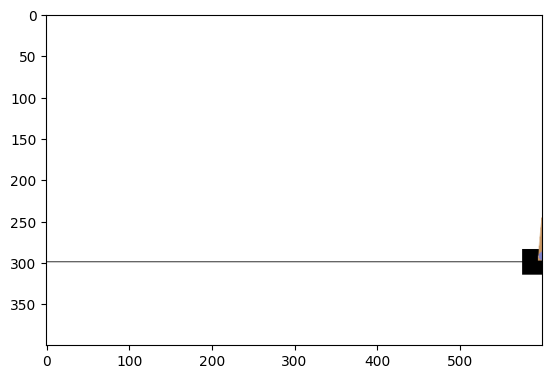

171.0

In [14]:
test(play=True)